In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import skimage
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import operator;
import re;
import collections;
import nltk
from nltk.corpus import stopwords
import gzip
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time

In [2]:
#!pip install --user wordCloud

In [3]:
from wordcloud import WordCloud
from textblob import TextBlob

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kbystrom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kbystrom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
wikidata = pd.read_json('data/wikidata-movies.json.gz', orient='record', lines=True)
genres = pd.read_json('data/genres.json.gz', orient='record', lines=True)
rotten = pd.read_json('data/rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('data/omdb-data.json.gz', orient='record', lines=True)

omdb.omdb_plot = omdb.omdb_plot.apply(lambda x: x.lower())

#Remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def removeStop (myText):
    word_tokens = word_tokenize(myText)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return(filtered_sentence);

omdb.omdb_plot = omdb.omdb_plot.apply(lambda x: removeStop(x))

In [6]:
texts = omdb.omdb_plot
texts = texts.apply(lambda x: ' '.join(word for word in x))
omdb.omdb_plot = texts
texts.head()

0    sprawling , star-laden film , see struggles va...
1    cryptic message past sends james bond rogue mi...
2    makers parody `` night living dead '' took geo...
3    jack crabb 121 years old film begins . collect...
4    perry girlfriend , gail , cross paths charisma...
Name: omdb_plot, dtype: object

In [7]:
stop = stopwords.words('english')
def clean_message(message): #I ended up not using this function because it returns a list
    clean_message = [word.lower() for word in message.split() if word.lower() not in stop]
    return clean_message

In [8]:
# Use the textblob package to get polarity (a scale version of sentiment)
omdb['Polarity'] = omdb.omdb_plot.apply(lambda x: TextBlob(x).sentiment.polarity)
omdb.head()

,imdb_id,omdb_awards,omdb_genres,omdb_plot,Polarity
0,tt0060814,Nominated for 2 Oscars. Another 2 nominations.,"[Drama, History, War]","sprawling , star-laden film , see struggles va...",-0.025000
1,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,"[Action, Adventure, Thriller]",cryptic message past sends james bond rogue mi...,-0.133058
2,tt0230575,N/A,"[Comedy, Horror]",makers parody `` night living dead '' took geo...,0.111111
3,tt0065988,Nominated for 1 Oscar. Another 5 wins & 8 nomi...,"[Adventure, Comedy, Drama]",jack crabb 121 years old film begins . collect...,0.051563
4,tt1995390,2 nominations.,"[Crime, Drama, Thriller]","perry girlfriend , gail , cross paths charisma...",0.126472


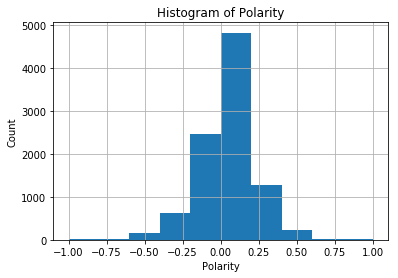

In [9]:
#Histogram of polarity
omdb.Polarity.hist()
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

In [10]:
#Check Polarity
omdb.omdb_plot[omdb.Polarity > .5].head()

61     based real life story legendary cryptanalyst a...
145    story canadian lt. gen. roméo dallaire , contr...
387    teenager darren excellent student pride joy pe...
398    man-cub mowgli flees jungle threat tiger shere...
401    16th century cévennes , horse dealer name mich...
Name: omdb_plot, dtype: object

In [11]:
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt)) for txt in omdb.omdb_plot]
#bagsofwords

In [12]:
len(omdb.omdb_plot)

9676

In [13]:
#delete non-English language
omdb = omdb[omdb.omdb_plot.str.contains(r'[^\x00-\x7F]+') == False]
omdb = omdb.reset_index(level=0, drop = True)
len(omdb.omdb_plot) # (9676-9244) = 432 movie plots were deleted for contianing non-ascii characters

9244

In [14]:
# Find list of unique words in the data frame
results = list(omdb['omdb_plot'].str.split(' ', expand=True).stack())


#Find top 200
from collections import Counter
top_200 = Counter(results).most_common(200)
print(top_200[0:10])

[(',', 47150), ('.', 35093), ("'s", 8801), (')', 2483), ('(', 2482), ('one', 2379), ('life', 2287), ('``', 1929), ("''", 1923), ('new', 1746)]


In [15]:
list_df = (omdb['omdb_plot'].str.split(' ', expand=True).stack())
from itertools import compress

#remove punctuation (somewhat crudely)
boolList = list_df.apply(lambda x: ("," not in x) and ("." not in x) and ("'" not in x) and ( "-" not in x) and ("(" not in x) and (")" not in x) and ( "`" not in x))
results = list(compress(list_df, boolList))
#list_df[1].apply(lambda x: len(x)) >=3

#Now let's recheck what the top results are:
top_500 = [item[0] for item in Counter(results).most_common(500)]
print(top_500[1:10]) #much better

['life', 'new', 'two', 'young', 'world', 'man', 'family', 'love', 'find']


In [23]:
def  word2vector(message):
    vec = np.zeros(500)
    for i in range(0,500):
        if top_500[i] in clean_message(message):
            vec[i] = 1
    return vec

In [25]:
#Check that the function is working
check = word2vector(omdb.omdb_plot[1])
print(set(check))
import matplotlib.pyplot as plt

{0.0, 1.0}


In [26]:
omdb['buckets'] = (omdb.omdb_plot.apply(lambda x: word2vector(x)))
omdb.head(n = 1)

,imdb_id,omdb_awards,omdb_genres,omdb_plot,Polarity,buckets
0,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,"[Action, Adventure, Thriller]",cryptic message past sends james bond rogue mi...,-0.133058,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
tempList = omdb.buckets.values.tolist()

In [28]:
omdb[top_500] = pd.DataFrame(omdb.buckets.tolist(), index= omdb.index)

In [29]:
omdb.head(n=1)

,imdb_id,omdb_awards,omdb_genres,omdb_plot,Polarity,buckets,one,life,new,two,...,changes,female,states,hit,identity,dies,accidentally,general,follow,fighting
0,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,"[Action, Adventure, Thriller]",cryptic message past sends james bond rogue mi...,-0.133058,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
omdb.to_csv("omdbBuckets.csv")

In [31]:
X = omdb.loc[:, 'one':'fighting']

In [32]:
kmeans = KMeans(n_clusters=10) # I want to cluster the movies into similar plots. I will try 10 first
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

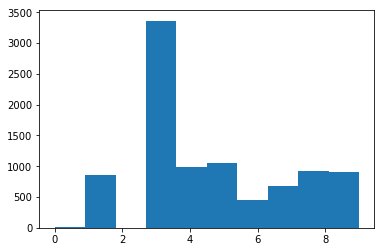

In [33]:
plt.hist(kmeans.predict(X))
plt.show()

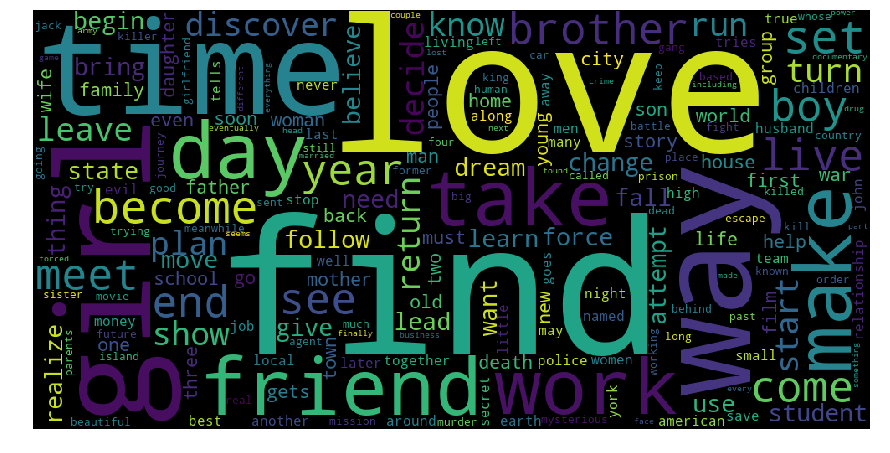

In [39]:
#Make a word cloud of the top 500 words
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(top_500))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [41]:
omdb["cluster"] = kmeans.predict(X)
omdb.head()

,imdb_id,omdb_awards,omdb_genres,omdb_plot,Polarity,buckets,one,life,new,two,...,female,states,hit,identity,dies,accidentally,general,follow,fighting,cluster
0,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,"[Action, Adventure, Thriller]",cryptic message past sends james bond rogue mi...,-0.133058,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,tt0230575,N/A,"[Comedy, Horror]",makers parody `` night living dead '' took geo...,0.111111,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,tt0065988,Nominated for 1 Oscar. Another 5 wins & 8 nomi...,"[Adventure, Comedy, Drama]",jack crabb 121 years old film begins . collect...,0.051563,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
3,tt1995390,2 nominations.,"[Crime, Drama, Thriller]","perry girlfriend , gail , cross paths charisma...",0.126472,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,tt0066921,Nominated for 4 Oscars. Another 9 wins & 19 no...,"[Crime, Drama, Sci-Fi]",protagonist alex delarge `` ultraviolent '' yo...,-0.042500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [55]:
#It might be interesting to check if different clusters have different sentiment
#!pip install --user plotnine
from plotnine import *
import numpy as np

    100% |████████████████████████████████| 3.6MB 203kB/s eta 0:00:01    42% |█████████████▌                  | 1.5MB 23.1MB/s eta 0:00:01
    100% |████████████████████████████████| 31.2MB 24kB/s  eta 0:00:01
    100% |████████████████████████████████| 71kB 5.7MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 5.6MB/s eta 0:00:01


In [51]:
omdb.loc[:,['Polarity', 'cluster']].head(n=2)

,Polarity,cluster
0,-0.133058,8
1,0.111111,3


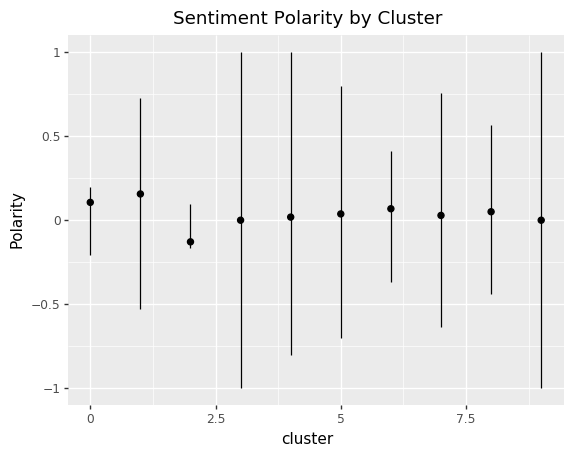

<ggplot: (8764127611389)>

In [57]:
#Let's see if the different clusters have different sentiment
ggplot(aes(x='cluster', y='Polarity'), data=omdb) + stat_summary(fun_y = np.median, 
                                                              fun_ymin=np.min,
                                                              fun_ymax=np.max) + ggtitle("Sentiment Polarity by Cluster")
#Answer: haha no they don't